<a href="https://colab.research.google.com/github/Thomasvidalenc/DMML2022_IWC/blob/main/SecondPart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcolme to the second part of our project where we will try a SVC classifier.

SVC classifier implements the Support Vector Machine (SVM) algorithm for classification tasks. We want to see if this model will be better than those in the first part

As always, we have to install and prepare the environment of work

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%%capture
! pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
!mkdir data

In [6]:
%%capture
! kaggle competitions download -c detecting-french-texts-difficulty-level-2022

In [7]:
%%capture
!unzip "detecting-french-texts-difficulty-level-2022.zip" -d data

In [9]:
%%capture
!pip install -U spacy
# Download the French language model
!python -m spacy download fr

In [10]:
sp = spacy.load('fr_core_news_sm')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn import svm
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.fr import French
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import seaborn as sns
from fonctionutile import *

In [12]:
df_training = pd.read_csv('/content/data/training_data.csv')
df_test = pd.read_csv('/content/data/unlabelled_test_data.csv')
df_sample = pd.read_csv('/content/data/sample_submission.csv')

We can explore our data to see if it exists problem in it

In [14]:
df_training.isnull().sum()

id            0
sentence      0
difficulty    0
dtype: int64

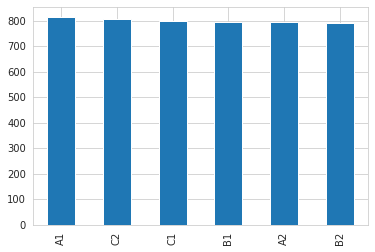

In [15]:
df_training['difficulty'].value_counts().plot(kind = 'bar')

We can see with the barplot that we have a correct diversity and we reduce thanks to that some bias

In [34]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence    4800 non-null   string
 1   difficulty  4800 non-null   object
 2   label       4800 non-null   int64 
dtypes: int64(1), object(1), string(1)
memory usage: 112.6+ KB


A sentence must be a string

In [ ]:
df_training['sentence'] = df_training['sentence'].astype('string')

Now, we will create a new column 'label' that will contains the encoded values from the column difficulty.

In [35]:
df_training['label'] = [0 if x == 'A1'
                   else 1 if x == 'A2'
                   else 2 if x == 'B1'
                   else 3 if x == 'B2'
                   else 4 if x == 'C1'
                   else 5
                   for x in df_training.difficulty]

In [36]:
oe=OrdinalEncoder()

# set the order of your categories
oe.set_params(categories= [['0', '1', '2','3','4','5']])

# fit-transform a dataframe of the categorical age variable
df_training['label']= oe.fit_transform(df_training[['label']])

# double check your encoder used the categories in the right order
oe.categories_

[array([0, 1, 2, 3, 4, 5])]

Finally, we transform our new column as integer we drop the column 'id' because we will not need it

In [19]:
df_training['label'] = df_training['label'].astype(int)
df_training = df_training.drop(['id'], axis = 1)

Let's take a look to our new training Dataframe

In [39]:
df_training

,sentence,difficulty,label
0,Les coûts kilométriques réels peuvent diverger...,C1,4.0
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,0.0
2,Le test de niveau en français est sur le site ...,A1,0.0
3,Est-ce que ton mari est aussi de Boston?,A1,0.0
4,"Dans les écoles de commerce, dans les couloirs...",B1,2.0
...,...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2,3.0
4796,Il avait une de ces pâleurs splendides qui don...,C1,4.0
4797,"Et le premier samedi de chaque mois, venez ren...",A2,1.0
4798,Les coûts liés à la journalisation n'étant pas...,C2,5.0


We can define our new x and y

In [21]:
X = df_training['sentence']
y = df_training['label']

We set 80% of train data and let 20% for the test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

#Try to construct a good classifier SVC()

we will use a TfidfVectorizer to convert the sentences into numerical feature vectors. We try to find the best combinaison of parameter for the vectorizer.

We are 

In [23]:
result = []
for config in configs:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, 
                                   ngram_range=config[0],
                                   min_df=config[1], max_df=config[2], analyzer=config[3])

    # Define classifier
    svc = svm.SVC()

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', svc)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    print("Accuracy ", accuracy_score(y_test, y_pred))
    print("-----------------------")

    # Append to result
    result.append([config, accuracy_score(y_test, y_pred)])

CONFIG:  [(1, 1), 1, 1.0, 'word']
Accuracy  0.41041666666666665
-----------------------
CONFIG:  [(1, 1), 1, 1.0, 'char']
Accuracy  0.4239583333333333
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'word']
Accuracy  0.4114583333333333
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'char']
Accuracy  0.48020833333333335
-----------------------
CONFIG:  [(1, 3), 1, 1.0, 'word']
Accuracy  0.39479166666666665
-----------------------
CONFIG:  [(1, 3), 1, 1.0, 'char']
Accuracy  0.490625
-----------------------
CONFIG:  [(2, 2), 1, 1.0, 'word']
Accuracy  0.26458333333333334
-----------------------
CONFIG:  [(2, 2), 1, 1.0, 'char']
Accuracy  0.4666666666666667
-----------------------
CONFIG:  [(2, 3), 1, 1.0, 'word']
Accuracy  0.24791666666666667
-----------------------
CONFIG:  [(2, 3), 1, 1.0, 'char']
Accuracy  0.5010416666666667
-----------------------
CONFIG:  [(3, 3), 1, 1.0, 'word']
Accuracy  0.2
-----------------------
CONFIG:  [(3, 3), 1, 1.0, 'char']
Accuracy  0.496875
----------

we can see above that the best combinaison is the following CONFIG:  [(2, 3), 1, 1.0, 'char']

Let's take a more precise look to this possibility

In [24]:
tfid = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(2,3), min_df=1, max_df=1.0, analyzer='char')

In [27]:
svc = svm.SVC()
pipe_svc = Pipeline([('vectorizer', tfid),
                 ('classifier', svc)])
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(2, 3),
                                 tokenizer=<function spacy_tokenizer at 0x7efc695f3af0>)),
                ('classifier', SVC())])

Show the accuracy, precision, recall and F1 score on the test set.

In [29]:
prediction = Prediction(pipe_svc, X_test)
Evaluate(y_test, prediction)

CLASSIFICATION REPORT:
	Accuracy: 0.5010
	Precision: 0.4992
	Recall: 0.5010
	F1_Score: 0.4974


We are not convinced with this model and we will not go further in our research on it. So, see you in part 3 where it will be more serious!